In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quant/__results__.html
/kaggle/input/quant/__notebook__.ipynb
/kaggle/input/quant/__output__.json
/kaggle/input/quant/df_mi
/kaggle/input/quant/df_scale_finale
/kaggle/input/quant/custom.css
/kaggle/input/quant/__results___files/__results___8_0.png
/kaggle/input/quant/__results___files/__results___55_1.png
/kaggle/input/quant/__results___files/__results___11_0.png
/kaggle/input/quant/__results___files/__results___39_0.png
/kaggle/input/quant/__results___files/__results___40_0.png
/kaggle/input/quant/__results___files/__results___62_3.png
/kaggle/input/quant/__results___files/__results___53_1.png
/kaggle/input/quant/__results___files/__results___10_0.png
/kaggle/input/quant/__results___files/__results___51_1.png
/kaggle/input/quant/__results___files/__results___62_2.png
/kaggle/input/quant/__results___files/__results___62_1.png
/kaggle/input/quant/__results___files/__results___49_1.png
/kaggle/input/quant/__results___files/__results___5_0.png
/kaggle/input/quant/__results_

In [ ]:
file ="../input/quant/df_mi"
#file ="../input/quant/df_scale_finale"
df = pd.read_csv(file)
df.head()

In [ ]:
import numpy as np
import pandas as pd
import warnings

## Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Sklearn Libraries
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve

# Define random state
random_state = 2018
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [ ]:


# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)



# Split data

In [ ]:
X = df.drop(['embauche'], axis = 1) 
y = df.embauche  
X.shape,y.shape

In [ ]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
            
        return train_pred, test_pred, recall_scores, f1_scores

In [ ]:
X = df.drop(['embauche'], axis=1)
y = df['embauche'].values

In [ ]:

from sklearn.model_selection import train_test_split

X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
X_train.shape, y_train.shape,X_test,y_test

In [ ]:
rdf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False,
            random_state=random_state,
            verbose=0, warm_start=False)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)

n_splits = 5
base_models = [rdf]
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)    

rdf = RandomForestClassifier(random_state = random_state) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [6, 8, 10, 20], 
              'min_samples_split': [5, 10, 15],
              'min_samples_leaf' : [4, 8, 12],
              'n_estimators' : [300, 400, 500]
             }


grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, y_train)

In [ ]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

In [ ]:
rdf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False,
            random_state=random_state,
            verbose=0, warm_start=False)

In [ ]:
base_models = [rdf1]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)     

In [ ]:
train_pred, test_pred, recall_scores, f1_scores = lgb_stack.predict(X_train, y_train, X_test)

In [ ]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

In [ ]:
tpred = pd.DataFrame(test_pred)
final_tpred = tpred.mode(axis=1)

In [31]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba, train_pred, test_pred

In [32]:
from sklearn.ensemble import RandomForestClassifier
class_weight = dict({1:1.9, 2:35})

rdf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False,
            random_state=random_state,
            verbose=0, warm_start=False)

In [33]:
base_models = [rdf]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)     

In [34]:
train_proba, test_proba, train_pred, test_pred = lgb_stack.predict(X_train, y_train, X_test)

Model- 0 and CV- 0 recall: 0.926994251714401, f1_score: 0.926908295125412
Model- 0 and CV- 1 recall: 0.9358795332405105, f1_score: 0.9358293875119433
Model- 0 and CV- 2 recall: 0.926986688180718, f1_score: 0.9269409894527434
Model- 0 and CV- 3 recall: 0.9304154901169827, f1_score: 0.9303767185666765
Model- 0 and CV- 4 recall: 0.9229528035498185, f1_score: 0.9229014165463754


In [35]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))

1. The F-1 score of the model 0.9285930906136601

2. The recall score of the model 0.9286463375282349

3. Classification report 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93     12396
           1       0.95      0.90      0.93     12396

    accuracy                           0.93     24792
   macro avg       0.93      0.93      0.93     24792
weighted avg       0.93      0.93      0.93     24792
 

4. Confusion matrix 
 [[11850   546]
 [ 1223 11173]] 



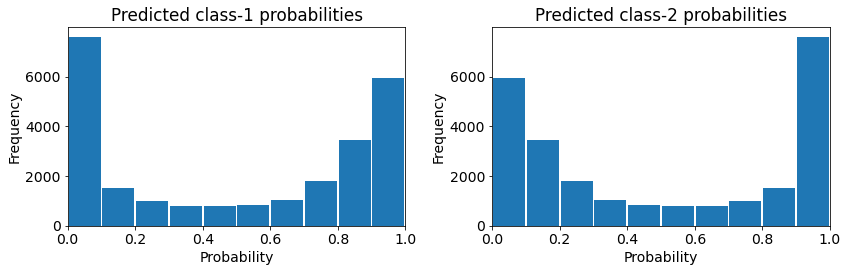

In [36]:


# histogram of predicted probabilities
plt.figure(figsize=(12, 4))
nclasses = 2
for i in range(nclasses):
    
    plt.subplot(1, 2, i+1)
    plt.hist(train_proba[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



In [37]:
!pip install jovian
import jovian

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
jovian.commit(project='Quant RF SMOTE best model with 3 best features')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/yeonathan/Quant RF SMOTE best model with 3 best features


<IPython.core.display.Javascript object>